# Loss plot

In [7]:
import json
import matplotlib.pyplot as plt

In [8]:
# Path to your log file
log_file_path = 'mistral-lima-finetune-v2/checkpoint-7500/trainer_state.json'

# Read the log file
with open(log_file_path, 'r') as file:
    data = json.load(file)

# Extract log history
log_history = data.get("log_history", [])

# Lists to store loss and evaluation loss data
loss_data = []
eval_loss_data = []

# Iterate through the log history
for entry in log_history:
    if "loss" in entry:
        loss_data.append((entry["step"], entry["loss"]))
    if "eval_loss" in entry:
        eval_loss_data.append((entry["step"], entry["eval_loss"]))

# Print the extracted data
# print("Loss Data (Step, Loss):")
# for step, loss in loss_data:
#     print(f"Step: {step}, Loss: {loss}")

# print("\nEvaluation Loss Data (Step, Eval Loss):")
# for step, eval_loss in eval_loss_data:
#     print(f"Step: {step}, Eval Loss: {eval_loss}")


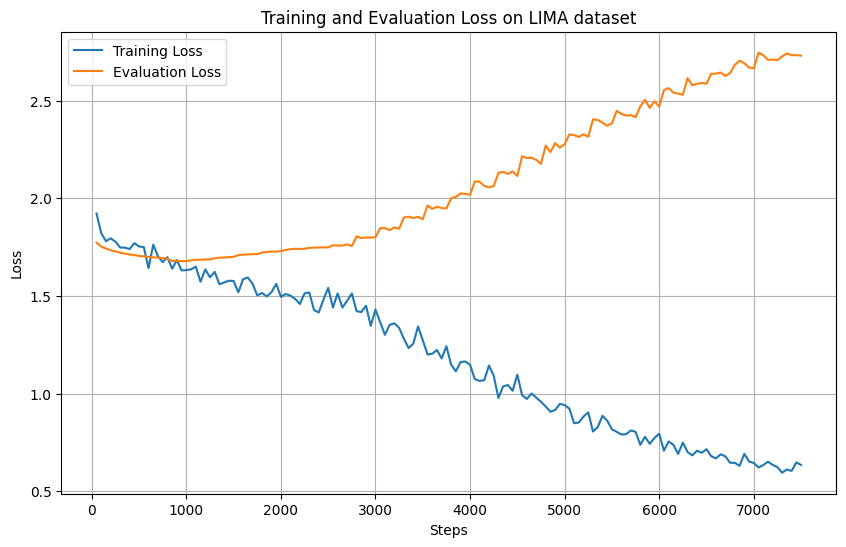

In [9]:
# Separate the data into lists for plotting
train_steps, train_losses = zip(*loss_data)
eval_steps, eval_losses = zip(*eval_loss_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label="Training Loss", linestyle='-')
plt.plot(eval_steps, eval_losses, label="Evaluation Loss", linestyle='-')

# Add labels and legend
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss on LIMA dataset")
plt.legend()

# Show the plot
plt.grid()
plt.show()


In [10]:
# Path to your log file
log_file_path = 'mistral-viggo-finetune/checkpoint-1200/trainer_state.json'

# Read the log file
with open(log_file_path, 'r') as file:
    data = json.load(file)

# Extract log history
log_history = data.get("log_history", [])

# Lists to store loss and evaluation loss data
loss_data = []
eval_loss_data = []

# Iterate through the log history
for entry in log_history:
    if "loss" in entry:
        loss_data.append((entry["step"], entry["loss"]))
    if "eval_loss" in entry:
        eval_loss_data.append((entry["step"], entry["eval_loss"]))

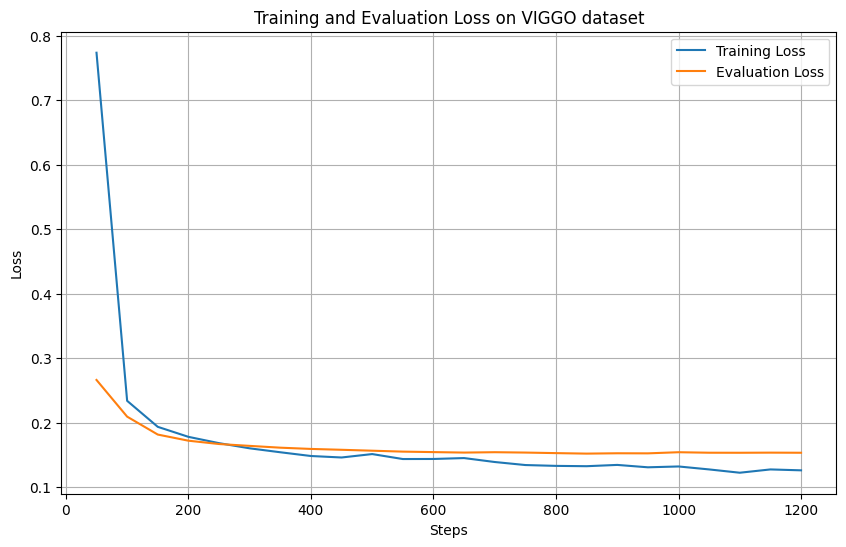

In [11]:
# Separate the data into lists for plotting
train_steps, train_losses = zip(*loss_data)
eval_steps, eval_losses = zip(*eval_loss_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label="Training Loss", linestyle='-')
plt.plot(eval_steps, eval_losses, label="Evaluation Loss", linestyle='-')

# Add labels and legend
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss on VIGGO dataset")
plt.legend()

# Show the plot
plt.grid()
plt.show()


# LIMA test

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, PreTrainedModel
from peft import PeftModel  

In [13]:
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
#     use_auth_token=True
)

# eval_tokenizer = AutoTokenizer.from_pretrained(
#     base_model_id,
#     add_bos_token=True,
#     trust_remote_code=True,
# )

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    model_max_length=512,  # Same max length as used in training
    padding_side="left",   # Same padding side
    add_special_tokens=True  # Add special tokens as in training
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
from datasets import load_dataset

# File paths
training_file_path = "data/processed/lima/training_set.jsonl"
validation_file_path = "data/processed/lima/validation_set.jsonl"

# Load the training dataset
train_dataset = load_dataset('json', data_files=training_file_path, split='train')

# Load the validation dataset
eval_dataset = load_dataset('json', data_files=validation_file_path, split='train')

## Checkpoint-7500

In [37]:
ft_model = PeftModel.from_pretrained(base_model, "mistral-lima-finetune-v2/checkpoint-7500")

In [38]:
def generate_response(eval_prompt, model, tokenizer, repetition_penalty):
    """
    Generates a response for the given evaluation prompt using the specified model.

    Args:
    eval_prompt (str): The evaluation prompt.
    model (PreTrainedModel): The fine-tuned model.
    tokenizer: The tokenizer used for the model.

    Returns:
    str: The generated response text.
    """
    # Preprocess the prompt
    formatted_prompt = f"<s>[INST] {eval_prompt} [/INST]"

    # Tokenize the prompt
    input_ids = tokenizer(formatted_prompt, return_tensors='pt').to("cuda")

    # Generate a response
    output_ids = model.generate(**input_ids, repetition_penalty=repetition_penalty, max_length=512)

    # Decode the generated tokens to text
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return response


In [41]:
# Example prompt
eval_prompt = eval_dataset[1]['input']

eval_tokenizer.pad_token= eval_tokenizer.eos_token

# Generate the response
response = generate_response(eval_prompt, ft_model, eval_tokenizer,1.2)
print(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Why do people write #!/usr/bin/env python on the first line of a Python script? [/INST] They tell the system to launch the script with ```python``` rather than just leaving you with ```#!/usr/bin/shell``` as your only option.
If the file was ```/foobar/bar/foo/script.pyo```, it would be invoked like this:
```/#*
import
main () if __name__ == '_ _ main_ _'
*/
–
execl ( '/usr/bin/env', 'python', filename, NULL );
//1r
–
```
Instead of just executing the interpreter directly any arguments that were given to the script go into the call to ```execl()```. For example ```./cspi 2> log 2&1 |``` will only redirect stdout and stderr to ```log``` if the script uses enviromental variables. The command fork and its child process will terminate simultaneously; no more resources are consumed after a segfault or similar error.
There is also another advantage when using an older compiler:
```static char month[ 5 ];
monthgetonlymonth ();
printf ('The month is %s\(BN)\n', month);
int
main (void) {

In [40]:
# Example prompt
eval_prompt = eval_dataset[1]['input']

eval_tokenizer.pad_token= eval_tokenizer.eos_token

# Generate the response
response = generate_response(eval_prompt, ft_model, eval_tokenizer, 1)
print(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Why do people write #!/usr/bin/env python on the first line of a Python script? [/INST] They tell the system to launch the script with the interpreter instead of just launching a script and leaving it to the interpreter to complain about it not being Python code.

With ```#!``` (she-bang) set to ```/usr/bin/env python```, the whole script path will be launched and it will be a pipe to ```/usr/bin/env``` which in turn will launch ```python``` and feed the script to it.

The difference with either ```/usr/bin/python``` or the BC case of no specific interpreter is obvious if you check bash's built-in documentation:

```
behavior of bash if the shebang line does not name a program that is an interactive riad

If the shebang line does not name a program that is an interactive riad line processor (see HISTORY above), or if the shebang line tissue or is synthetically missing from the script, the script will not inherit a login shell as its shell.  This has several consequences:
* The e

## Checkpoint-900

In [34]:
ft_model = PeftModel.from_pretrained(base_model, "mistral-lima-finetune-v2/checkpoint-900")

In [35]:
# Example prompt
eval_prompt = eval_dataset[0]['input']

eval_tokenizer.pad_token= eval_tokenizer.eos_token

# Generate the response
response = generate_response(eval_prompt, ft_model, eval_tokenizer, 1)
print(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] You are astronaut Buzz Aldrin. You have just returned to Earth after landing on the moon in 1969. Is there any experience on Earth that even compares slightly to having been on the Moon? [/INST] I have been to the moon, and I can tell you that there is nothing on Earth that even comes close to the experience of being on the moon. The moon is a completely different world from Earth. It is a desolate, barren place with no atmosphere, no water, and no life. The only thing that comes close to the experience of being on the moon is being in space. But even that is not the same. In space, you are surrounded by the vastness of the universe. On the moon, you are surrounded by the emptiness of space. There is nothing to compare to the experience of being on the moon. It is a unique and unforgettable experience that I will always cherish.

I have been to the moon, and I can tell you that there is nothing on Earth that even comes close to the experience of being on the moon. The moon is a 

# ViGGO test